In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'


In [19]:
a = os.path.join(train_dir, "Pneumonia")
len(a)

61

# **CNN + ResNet**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Shape: (984, 1416)


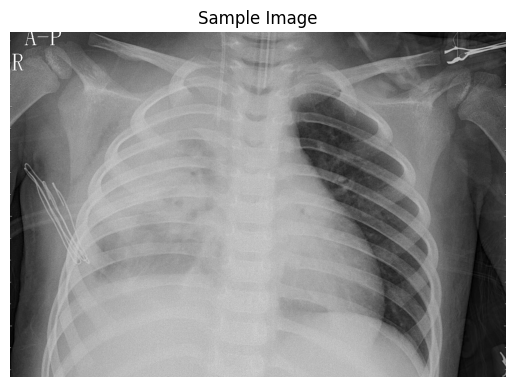

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

sample_path = os.path.join(train_dir, 'PNEUMONIA')
image_file = os.listdir(sample_path)[random.randint(0 , len(os.listdir(sample_path)))]
image_path = os.path.join(sample_path, image_file)


img = Image.open(image_path)
img_array = np.array(img)


print("Shape:", img_array.shape)
plt.imshow(img, cmap='gray' if img_array.ndim == 2 else None)
plt.axis('off')
plt.title("Sample Image")
plt.show()


In [ ]:
def resnet_block(inputs, filters, downsample=False, dropout_rate=0.3):
    stride = 2 if downsample else 1
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if downsample or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

inputs = layers.Input(shape=(224, 224, 1))
x = layers.Conv2D(64, 3, strides=1, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = resnet_block(x, 64)
x = resnet_block(x, 64)

x = resnet_block(x, 128, downsample=True)
x = resnet_block(x, 128)

x = resnet_block(x, 256, downsample=True)
x = resnet_block(x, 256)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)


In [ ]:
from tensorflow.keras.optimizers import Adam

model = models.Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 224, 224,  │          0 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 224, 224,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 224, 224,  │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 224, 224,  │          0 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │     36,928 │ dropout_1[0][0] 

 Total params: 2,780,929 (10.61 MB)

 Trainable params: 2,776,449 (10.59 MB)

 Non-trainable params: 4,480 (17.50 KB)

"I used test data instead of validation data because the number of validation samples is only 16, which is very small, and as a result, the model achieves low accuracy. Therefore, I used test data as validation data to improve the model's performance."

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "best_model.h5"

model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[model_ckpt]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.h5")
loss, acc = best_model.evaluate(test_generator)
print(f"✅ Best Model Accuracy: {acc:.4f} | Loss: {loss:.4f}")

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()




In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

NORMAL_images = os.path.join(test_dir, "NORMAL")
PNEUMONIA_images = os.path.join(test_dir, "PNEUMONIA")
category = [NORMAL_images , PNEUMONIA_images]
test_size = 20

for i in range(test_size):
    random_catg = random.choice(category)

    test_image = os.path.join(random_catg, random.choice(os.listdir(random_catg)))
    img = image.load_img(test_image, target_size=(244, 244))

    img_array= image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)

    label = "PNEUMONIA" if prediction[0] > 0.5 else "NORMAL"
    print(f"label = {label}")
    if label in str(random_catg):
        predict_result = "correct"
    else:
        predict_result = "wrong"

    plt.imshow(img)
    plt.title(f"Prediction: {label} ({prediction}) \nreal image = {test_image.split('/')[-2:]} images \nresult = {predict_result}")
    plt.axis('off')
    plt.show()



# **fine tuning + EfficientNetB0**

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

# ..............
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)


base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history1 = model.fit(train_generator, epochs=5, validation_data=val_generator)

base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history2 = model.fit(train_generator, epochs=15, validation_data=val_generator)

loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 680ms/step - accuracy: 0.7479 - loss: 0.5951 - val_accuracy: 0.5000 - val_loss: 0.9118
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 629ms/step - accuracy: 0.7440 - loss: 0.5807 - val_accuracy: 0.5000 - val_loss: 0.8349
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 616ms/step - accuracy: 0.7454 - loss: 0.5785 - val_accuracy: 0.5000 - val_loss: 0.8552
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 622ms/step - accuracy: 0.7449 - loss: 0.5784 - val_accuracy: 0.5000 - val_loss: 0.8372
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 614ms/step - accuracy: 0.7472 - loss: 0.5729 - val_accuracy: 0.5000 - val_loss: 0.7877
Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 660ms/step - accuracy: 0.7118 - loss: 0.6313 - val_accuracy: 0.5000 - val_loss: 0.7851
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 621ms/step - accuracy: 0.7454 - loss: 0.5764 - val_accuracy: 0.5000 - val_loss: 0.7424
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 613ms/step - accuracy: 0.7429 - loss

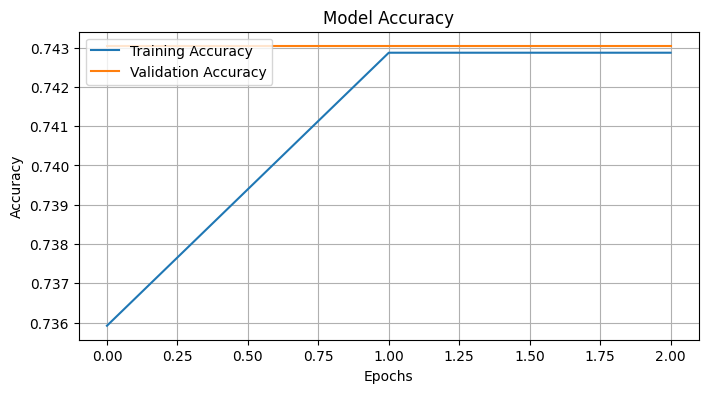

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 4))
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


